<a href="https://colab.research.google.com/github/pditi5/Thane-Transportation-Passenger-Flow-Prediction-Research-Project/blob/main/stl_lstms_seasonal_component.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'file5-pre-processing-data-pt2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5407961%2F8980829%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T035646Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da32698b61bdc9184abf20c04c46af7c013ad20842fd52a03c77a82248345df3265e60f8e9f4e6c424492cab5a21ec4d14077aa34d3f365cf6e8565a1d26fab888085c2157baf46fb631d72673cf8441bfe6131898d080369e27f816bbc6fbac00dd41b025c670012f68bbe6bc4a83d7971f21d1aef641c089a7685ae77c2825a7b9acb321ab2c52eb91a09e2bd5381d3bc3e8cd36d2f3f35484407e51578203a28e8b44c848573f112ce1fdcfefacecb479d0e81c4d13ca160f0cee345fb9748aad6336a4304fa8c64f6f6c3e9094f1271a3432689797cb37c8314bfc8e9bd5854001384fd6f02dbaa9bd37de52a454c30b59cb52b95a80273e4ca3c57b6f865,results:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5416458%2F8992608%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T035646Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4726e5e4684d1906abd1b945fe0eda03a29e9ec52bfbe405c131e5d321e05187b8534e76bc8c649de1d32f30a1760e96392867692859bc45b5fe5a4736e0125d2193698e3f77722d27e9aa1b97f7757b5030683d4320c10f2be8f701f10a29d4f8c0a965dfb3a345849b7f94f9ae2a4dbf63062ffbdd8cfa55712f492bcd40490343c65e3aaf0fa78cca7a156aba74950121f7b4f61133f390228cc7b5fc5a38fa160c750dbe224cacdba2640bf31f25b3b02d982ae9c6164a76f5e90d889f41b33cb635e7fb9bd3c01671a4d34a3e2a6c4e1441407d39af347768d99a9a1c80fd89a0a77341f41c75820786b473555142ef41b611e0531a04c01283c5e53692'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/file5-pre-processing-data-pt2/File5 (2) - data pre-processing pt.2.csv
/kaggle/input/results/Result.csv


In [ ]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 75.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
#import shap
import optuna
import joblib
#!pip install openpyxl
from feature_engine.timeseries.forecasting import LagFeatures
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping

2024-07-25 09:41:11.337518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 09:41:11.337674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 09:41:11.472038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if y_true.ndim > 1:
        y_true = y_true.flatten()  # Flatten if y_true is 2-dimensional
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()  # Flatten if y_pred is 2-dimensional

    non_zero_mask = (y_true != 0) & (y_pred != 0)  # Exclude zero values from calculation
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if len(y_true) != 0 else np.nan

In [ ]:
df = pd.read_csv('/kaggle/input/file5-pre-processing-data-pt2/File5 (2) - data pre-processing pt.2.csv')
df

,Date_Time,Sid,Did,Station_Pair,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Passenger_Count
0,2018-06-01 00:00:00,5.0,14.0,Civil/Court-Pawar Nagar,0,0,1,6,2018,4,0.0
1,2018-06-01 01:00:00,5.0,14.0,Civil/Court-Pawar Nagar,0,0,2,6,2018,4,0.0
2,2018-06-01 02:00:00,5.0,14.0,Civil/Court-Pawar Nagar,0,0,3,6,2018,4,0.0
3,2018-06-01 03:00:00,5.0,14.0,Civil/Court-Pawar Nagar,0,0,4,6,2018,4,0.0
4,2018-06-01 04:00:00,5.0,14.0,Civil/Court-Pawar Nagar,0,0,5,6,2018,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
619483,2024-04-20 19:00:00,12.0,8.0,Voltas Gate-Thane Station West,0,0,20,4,2024,5,36.0
619484,2024-04-20 20:00:00,12.0,8.0,Voltas Gate-Thane Station West,0,0,21,4,2024,5,44.0
619485,2024-04-20 21:00:00,12.0,8.0,Voltas Gate-Thane Station West,0,0,22,4,2024,5,6.0
619486,2024-04-20 22:00:00,12.0,8.0,Voltas Gate-Thane Station West,0,0,23,4,2024,5,4.0


In [ ]:
#Convert Date Column to DateTime:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%Y-%m-%d %H:%M:%S')

# Replaces hyphens, spaces, and slashes in the 'Station_Pair' column with underscores.
df['Station_Pair'] = df['Station_Pair'].apply(lambda x: x.replace('-','_'))
df['Station_Pair'] = df['Station_Pair'].apply(lambda x: x.replace(' ','_'))
df['Station_Pair'] = df['Station_Pair'].apply(lambda x: x.replace('/','_'))

#Extract Hour from DateTime:
df['hour'] = df['Date_Time'].dt.hour

In [ ]:
df.columns.to_list()

['Date_Time',
 'Sid',
 'Did',
 'Station_Pair',
 'Is_Holiday',
 'Holiday_Type',
 'OneHourSlot',
 'Month',
 'Year',
 'Weekday',
 'Passenger_Count',
 'hour']

In [ ]:
df['Station_Pair'].nunique() , df['Station_Pair'].unique()

(12,
 array(['Civil_Court_Pawar_Nagar', 'Civil_Court_Thane_Station_West',
        'Civil_Court_Voltas_Gate', 'Pawar_Nagar_Civil_Court',
        'Pawar_Nagar_Thane_Station_West', 'Pawar_Nagar_Voltas_Gate',
        'Thane_Station_West_Civil_Court', 'Thane_Station_West_Pawar_Nagar',
        'Thane_Station_West_Voltas_Gate', 'Voltas_Gate_Civil_Court',
        'Voltas_Gate_Pawar_Nagar', 'Voltas_Gate_Thane_Station_West'],
       dtype=object))

In [ ]:
# Aggregate passenger count for each station pair
agg_df = df.groupby('Station_Pair')['Passenger_Count'].sum().reset_index()

# Calculate total passenger count
total_passenger_count = agg_df['Passenger_Count'].sum()

# Calculate percentage contribution for each station pair
agg_df['Percentage_Contribution'] = (agg_df['Passenger_Count'] / total_passenger_count) * 100

# Sort the DataFrame in Descending order of passenger count values
agg_df = agg_df.sort_values(by='Passenger_Count', ascending=False)

# Create a new DataFrame with the required columns
passenger_count_contributions = agg_df[['Station_Pair', 'Passenger_Count', 'Percentage_Contribution']]

# Filter out the top 3 station pairs with the highest passenger count values and contributions
top_3_station_pairs = passenger_count_contributions.nlargest(3, 'Passenger_Count')

# Display the new DataFrame
print(passenger_count_contributions)
print("\nTop 3 station pairs with highest passenger count values and contributions:")
print(top_3_station_pairs)

                      Station_Pair  Passenger_Count  Percentage_Contribution
7   Thane_Station_West_Pawar_Nagar        6397747.0                27.211537
4   Pawar_Nagar_Thane_Station_West        5361039.0                22.802107
8   Thane_Station_West_Voltas_Gate        4843920.0                20.602645
11  Voltas_Gate_Thane_Station_West        2900707.0                12.337577
3          Pawar_Nagar_Civil_Court        1454484.0                 6.186357
0          Civil_Court_Pawar_Nagar        1026884.0                 4.367646
1   Civil_Court_Thane_Station_West         482307.0                 2.051396
9          Voltas_Gate_Civil_Court         358895.0                 1.526488
2          Civil_Court_Voltas_Gate         271393.0                 1.154316
6   Thane_Station_West_Civil_Court         189847.0                 0.807476
10         Voltas_Gate_Pawar_Nagar         113560.0                 0.483005
5          Pawar_Nagar_Voltas_Gate         110373.0                 0.469449

In [ ]:
#Filters the DataFrame df to include only the rows where the value in the 'Station_Pair' column is one of the values
#in the keep_station_pair list.
#The filtered DataFrame is stored in a new DataFrame called df_filter_2.

keep_station_pair=['Thane_Station_West_Pawar_Nagar']


df_filter_2 = df[df['Station_Pair'].isin(keep_station_pair)]

In [ ]:
# df['covid'] = 0
# df.loc[(df['Date_Time']>=pd.Timestamp(2020,4,1))&(df['Date_Time']<pd.Timestamp(2021,1,1)),'covid'] = 3
# df.loc[(df['Date_Time']>=pd.Timestamp(2021,1,1))&(df['Date_Time']<pd.Timestamp(2021,2,1)),'covid'] = 2
# df.loc[(df['Date_Time']>=pd.Timestamp(2021,4,1))&(df['Date_Time']<pd.Timestamp(2021,6,1)),'covid'] = 2
# df.loc[(df['Date_Time']>=pd.Timestamp(2021,2,1))&(df['Date_Time']<pd.Timestamp(2021,4,1)),'covid'] = 1
# df.loc[(df['Date_Time']>=pd.Timestamp(2021,6,1))&(df['Date_Time']<pd.Timestamp(2022,1,1)),'covid'] = 1
# df_filter_2 = df[df['Date_Time']< pd.Timestamp(2024,4,20)]
# df_filter_2


#This creates two date values: one for January 1, 2019 (start_date) and one for April 20, 2024 (end_date).
start_date = pd.Timestamp(2019, 1, 1)  # 1st January 2019
end_date = pd.Timestamp(2024, 4, 20)   #20th April 2024


# filters df_filter_2 to keep only the rows where the 'Date_Time' column is between the start_date and the end_date.
#It means it keeps the data from January 1, 2019, up to but not including April 20, 2024.
df_filter_2 = df_filter_2[(df_filter_2['Date_Time'] >= start_date) & (df['Date_Time'] < end_date)]

/tmp/ipykernel_33/1244712175.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filter_2 = df_filter_2[(df_filter_2['Date_Time'] >= start_date) & (df['Date_Time'] < end_date)]


In [ ]:
df_filter_2['Station_Pair'].nunique() , df_filter_2['Station_Pair'].unique()

(1, array(['Thane_Station_West_Pawar_Nagar'], dtype=object))

In [ ]:
# df_filter_2 = df_filter_2[df_filter_2['Year'] >= 2022]
df_filter_2.reset_index(inplace=True,drop=True)
df_filter_2

,Date_Time,Sid,Did,Station_Pair,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Passenger_Count,hour
0,2019-01-01 00:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,1,1,2019,1,19.0,0
1,2019-01-01 01:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,2,1,2019,1,18.0,1
2,2019-01-01 02:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,3,1,2019,1,0.0,2
3,2019-01-01 03:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,4,1,2019,1,0.0,3
4,2019-01-01 04:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,5,1,2019,1,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,20,4,2024,4,231.0,19
46460,2024-04-19 20:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,21,4,2024,4,232.0,20
46461,2024-04-19 21:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,22,4,2024,4,127.0,21
46462,2024-04-19 22:00:00,8.0,14.0,Thane_Station_West_Pawar_Nagar,0,0,23,4,2024,4,74.0,22


In [ ]:
from statsmodels.tsa.seasonal import STL

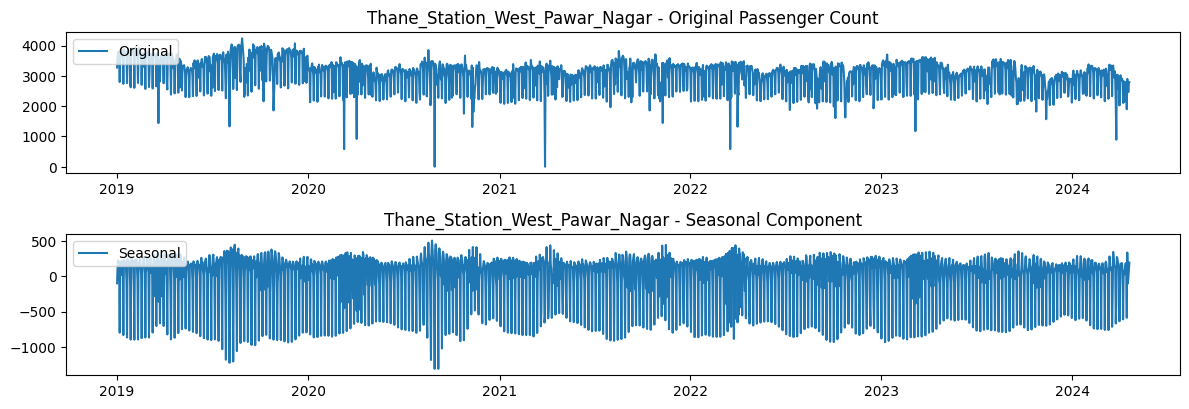

In [ ]:
# STL Decomposition
for sp in df_filter_2['Station_Pair'].unique():
    df_one_station_pair = df_filter_2[df_filter_2['Station_Pair'] == sp].copy()

    # Use all years from 2019 to 2024 for STL Decomposition
    df_one_station_pair.set_index('Date_Time', inplace=True)
    df_one_station_pair = df_one_station_pair.drop(columns=['Sid', 'Did', 'Station_Pair', 'hour'], errors='ignore')

    numeric_cols = df_one_station_pair.select_dtypes(include=[np.number]).columns.tolist()
    df_hourly_temp = df_one_station_pair[numeric_cols].resample('D').sum()

    # STL decomposition with hourly seasonality
    stl = STL(df_hourly_temp['Passenger_Count'], seasonal=7)
    result = stl.fit()

    seasonal = result.seasonal

    # Plot the decomposed components
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(df_hourly_temp['Passenger_Count'], label='Original')
    plt.title(f'{sp} - Original Passenger Count')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(seasonal, label='Seasonal')
    plt.title(f'{sp} - Seasonal Component')
    plt.legend(loc='upper left')

    #plt.subplot(413)
    #plt.plot(trend, label='Trend')
    #plt.title(f'{sp} - Trend Component')
    #plt.legend(loc='upper left')

    #plt.subplot(414)
    #plt.plot(residual, label='Residual')
    #plt.title(f'{sp} - Residual Component')
    #plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()




In [ ]:
# Function to perform STL decomposition
def perform_stl_decomposition(df):
    df_temp = df.copy()
    numeric_cols = df_temp.select_dtypes(include=[np.number]).columns.tolist()
    df_daily_temp = df_temp[numeric_cols].resample('D').sum()
    stl = STL(df_daily_temp['Passenger_Count'], seasonal=7)
    result = stl.fit()
    seasonal = result.seasonal
    trend =  result.trend
    residual = result.resid
    return seasonal
    #return trend
    #return residual

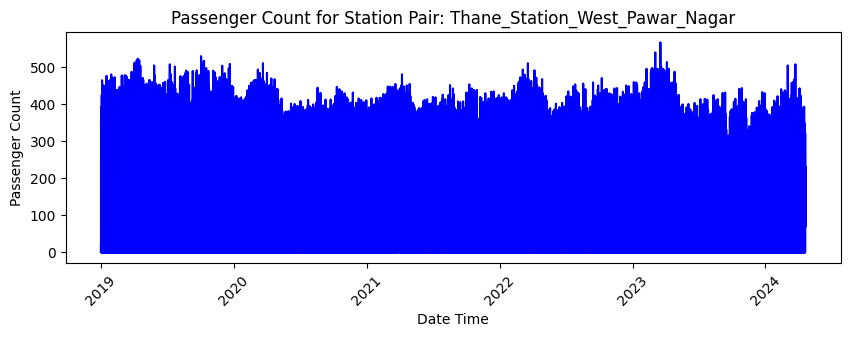

In [ ]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Loop over each unique station pair
for sp in df_filter_2['Station_Pair'].unique():
    df_one_station_pair = df_filter_2[df_filter_2['Station_Pair'] == sp]

    random.seed(100)
    np.random.seed(100)
    tf.random.set_seed(100)

    plt.figure(figsize=(10, 3))
    plt.plot(df_one_station_pair['Date_Time'].to_numpy(), df_one_station_pair['Passenger_Count'].to_numpy(), color='blue')
    plt.title(f"Passenger Count for Station Pair: {sp}")
    plt.xlabel('Date Time')
    plt.ylabel('Passenger Count')
    plt.tick_params('x', labelrotation=45)
    plt.savefig(f"Passenger_Count_{sp}.png")  # Save the plot as a PNG file
    plt.show()

In [ ]:
# Perform STL decomposition
seasonal = perform_stl_decomposition(df_one_station_pair.set_index('Date_Time'))

# Add STL components to the dataframe

In [ ]:
    lag_transformer = LagFeatures(variables=['Passenger_Count'], periods=[1,2,24,24*7,24*14,24*21,24*28])
    df_one_station_pair_lag = lag_transformer.fit_transform(df_one_station_pair)


    # create X & y for modelling (Feature Matrix X and Y )


    df_one_station_pair_lag_2 = df_one_station_pair_lag.dropna()
    X = df_one_station_pair_lag_2.drop(columns=['Date_Time','Sid','Did','Station_Pair','Passenger_Count']) # Feature Matrix X
    y = df_one_station_pair_lag_2['Passenger_Count'] # Target Variable

    # split into train & test

    X_train = X.iloc[:int(np.round((0.95*len(X)))),:]
    X_test = X.iloc[int(np.round((0.95*len(X)))):,:]
    y_train = y[:int(np.round((0.95*len(X))))]
    y_test = y[int(np.round((0.95*len(X)))):]


    # normalizing train set & reshape

    sc_X = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_X.fit_transform(X_train)
    X_train_scaled_2 = np.reshape(X_train_scaled,(X_train_scaled.shape[0],X_train_scaled.shape[1],1))
    #joblib.dump(sc_X, f'E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\Scaler\\scaler_X_{sp}')
    joblib.dump(sc_X, f'/kaggle/working/scaler_X_{sp}.joblib')

    sc_y = MinMaxScaler(feature_range = (0, 1))
    y_train_scaled = sc_y.fit_transform(np.reshape(y_train,(len(y_train),1)))
    #joblib.dump(sc_y, f'E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\Scaler\\scaler_y_{sp}')
    joblib.dump(sc_y, f'/kaggle/working/scaler_y_{sp}.joblib')


    # normalizing test set & reshape

    X_test_scaled = sc_X.transform(X_test)
    X_test_scaled_2 = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

    #path_best_model = f"E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\Models\\{sp}.keras"
    path_best_model = f"/kaggle/working/{sp}.keras"
    best_loss = 100

In [ ]:
df_one_station_pair_lag['Seasonal'] = seasonal.reindex(df_one_station_pair_lag.index).values
#df_one_station_pair_lag['Trend'] = trend.reindex(df_one_station_pair_lag.index).values
#df_one_station_pair_lag['Residual'] = residual.reindex(df_one_station_pair_lag.index).values

df_one_station_pair_lag_2 = df_one_station_pair_lag.dropna()
X = df_one_station_pair_lag_2.drop(columns=['Date_Time','Sid','Did','Station_Pair','Passenger_Count'])
y = df_one_station_pair_lag_2['Passenger_Count']

In [ ]:
df_one_station_pair_lag_2

,Date_Time,Sid,Did,Station_Pair,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Passenger_Count,hour,Passenger_Count_lag_1,Passenger_Count_lag_2,Passenger_Count_lag_24,Passenger_Count_lag_168,Passenger_Count_lag_336,Passenger_Count_lag_504,Passenger_Count_lag_672,Seasonal


In [ ]:
    def objective(trial):
        es = EarlyStopping(patience=5)
        # regressor = Sequential()
        # regressor.add(LSTM(units = trial.suggest_int('lstm',2,512), return_sequences = False, input_shape = (X_train.shape[1], 1)))
        # regressor.add(Dropout(trial.suggest_categorical('dropout',[0.1,0.2,0.4,0.6,0.8])))
        # regressor.add(Dense(units = 1))

        # Your original code
        regressor = Sequential()
        regressor.add(LSTM(units=trial.suggest_int('lstm', 2, 512), return_sequences=True, input_shape=(X_train.shape[1], 1)))
        regressor.add(Dropout(trial.suggest_categorical('dropout', [0.1, 0.2, 0.4, 0.6, 0.8])))

        # Adding one more LSTM layer
        regressor.add(LSTM(units=trial.suggest_int('lstm_2', 2, 512), return_sequences=False))

        # Output layer
        regressor.add(Dense(units=1))

        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = regressor.fit(X_train_scaled_2, y_train_scaled,  batch_size= trial.suggest_int('bs',32,512), epochs = 5,validation_split=0.1, callbacks=[es],shuffle=False)

        loss = history.history['val_loss'][-1]
        global best_loss
        if loss < best_loss:
            regressor.save(path_best_model)
            best_loss = loss
        del regressor
        return loss

    study = optuna.create_study(
        direction='minimize',
        load_if_exists=True)
    study.optimize(objective, n_trials=5)

[I 2024-07-25 09:42:49,118] A new study created in memory with name: no-name-e9096305-49ef-4223-8997-bde447c35136
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 55s 208ms/step - loss: 0.0089 - val_loss: 0.0023
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 206ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 203ms/step - loss: 0.0023 - val_loss: 0.0022


[I 2024-07-25 09:48:41,145] Trial 0 finished with value: 0.0022002821788191795 and parameters: {'lstm': 480, 'dropout': 0.6, 'lstm_2': 100, 'bs': 158}. Best is trial 0 with value: 0.0022002821788191795.


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 568ms/step - loss: 0.0141 - val_loss: 0.0023
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 565ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 565ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 567ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 558ms/step - loss: 0.0023 - val_loss: 0.0022


[I 2024-07-25 09:54:39,119] Trial 1 finished with value: 0.002220963826403022 and parameters: {'lstm': 458, 'dropout': 0.1, 'lstm_2': 236, 'bs': 412}. Best is trial 0 with value: 0.0022002821788191795.


Epoch 1/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - loss: 0.0114 - val_loss: 0.0024
Epoch 2/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 0.0024 - val_loss: 0.0022


[I 2024-07-25 09:55:58,273] Trial 2 finished with value: 0.0022081034258008003 and parameters: {'lstm': 164, 'dropout': 0.2, 'lstm_2': 62, 'bs': 145}. Best is trial 0 with value: 0.0022002821788191795.


Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 336ms/step - loss: 0.0202 - val_loss: 0.0024
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 328ms/step - loss: 0.0022 - val_loss: 0.0022


[I 2024-07-25 09:58:25,944] Trial 3 finished with value: 0.0021630278788506985 and parameters: {'lstm': 52, 'dropout': 0.1, 'lstm_2': 379, 'bs': 502}. Best is trial 3 with value: 0.0021630278788506985.


Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - loss: 0.0289 - val_loss: 0.0045
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.0087 - val_loss: 0.0039
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - loss: 0.0076 - val_loss: 0.0032
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0073 - val_loss: 0.0033


[I 2024-07-25 10:00:11,535] Trial 4 finished with value: 0.003279617056250572 and parameters: {'lstm': 2, 'dropout': 0.6, 'lstm_2': 311, 'bs': 184}. Best is trial 3 with value: 0.0021630278788506985.


 # predict on test set

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
rmse: 27.506251770513593
r2: 0.9093651226530083
mape: 29.36925004370347
mae: 18.510917030567686


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


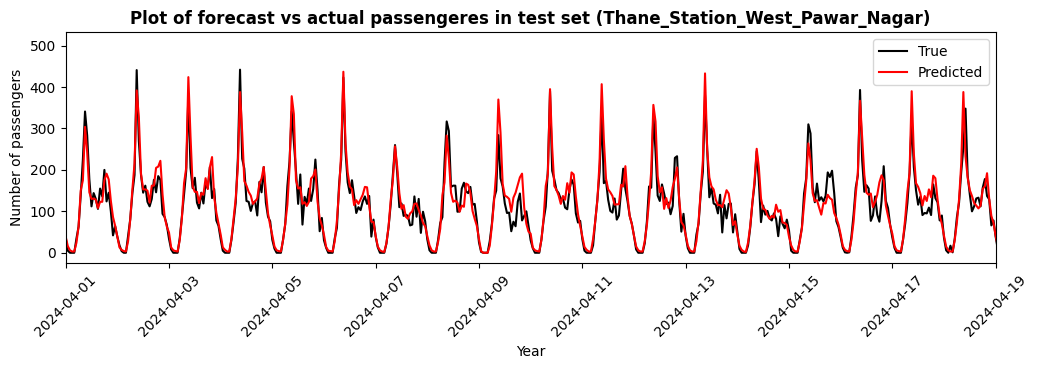

In [ ]:
    #model = tf.keras.models.load_model(f'E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\Models\\{sp}.keras')
    model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
    # model = tf.keras.models.load_model('test.keras')
    pred_inverse = model.predict(X_test_scaled_2)
    pred_2 = sc_y.inverse_transform(pred_inverse)
    pred = np.floor(pred_2)
    pred = np.where(pred<0, 0, pred)
    # pred_list.append(pred)
    rmse=mean_squared_error(y_test,pred,squared=False)
    rscore=r2_score(y_test,pred)
    mape=mean_absolute_percentage_error(y_test,pred)
    mae=mean_absolute_error(y_test,pred)
    print('rmse:', mean_squared_error(y_test,pred,squared=False))
    print('r2:', r2_score(y_test,pred))
    print('mape:', mean_absolute_percentage_error(y_test,pred))
    print('mae:', mean_absolute_error(y_test,pred))

    ind = X_test.index
    xlabel = df_filter_2.loc[ind,'Date_Time'].to_numpy()
    plt.figure(figsize=(12, 3))
    plt.plot(xlabel,y_test.to_numpy(),c='black',label='True')
    plt.plot(xlabel,pred,label='Predicted',c='red')
    plt.legend(loc=1)
    plt.title(f'Plot of forecast vs actual passengeres in test set ({sp})',fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Number of passengers')
    plt.xlim((pd.Timestamp(2024,4,1),pd.Timestamp(2024,4,19)))
    plt.tick_params('x',labelrotation=45)
    # Save the figure
    #plt.savefig(f'E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\Graphs\\{sp}.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.savefig(f'/kaggle/working/{sp}.tiff', format='tiff', dpi=300, bbox_inches='tight')

    plt.show()

    best_params = study.best_params

# Append to Excel Function

In [ ]:
    def append_to_excel(file_path, data):
        try:
            # Load existing workbook or create a new one
            try:
                wb = load_workbook(file_path)
                ws = wb.active
            except FileNotFoundError:
                wb = Workbook()
                ws = wb.active
                ws.append(['sp',"All Years", 'lstm', 'dropout', 'lstm_2', 'bs', 'rmse', 'r2', 'mae', 'mape'])

            # Append data to the next available row
            ws.append(data)

            # Save the workbook
            wb.save(file_path)
            print("Data appended to Excel file successfully.")
        except Exception as e:
            print(f"Error: {e}")
    lstm_value = best_params['lstm']
    dropout_value = best_params['dropout']
    lstm_2_value = best_params['lstm_2']
    bs_value = best_params['bs']

    # Append the data to the Excel file
    data_to_append = [sp,"All Years", lstm_value, dropout_value, lstm_2_value, bs_value,rmse,rscore,mape,mae]
    #file_path = 'E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\Result.xlsx'
    file_path = '/kaggle/working/Result.xlsx'
    append_to_excel(file_path, data_to_append)

Data appended to Excel file successfully.


# 1st Jan 2022 to 1st June 2022

In [ ]:
    df_one_station_pair = df_filter_2[df_filter_2['Station_Pair']==sp]


                                                                          ##### =pd.Timestamp(2022,1,1))&(df_one_station_pair['Date_Time']<pd.Timestamp(2022,6,1))]???????????
    # create lag features
    lag_transformer = LagFeatures(variables=['Passenger_Count'], periods=[1,2,24,24*7,24*14,24*21,24*28])
    df_one_station_pair_lag = lag_transformer.fit_transform(df_one_station_pair)

    # create X & y for modelling
    df_one_station_pair_lag_2 = df_one_station_pair_lag.dropna()
    X = df_one_station_pair_lag_2.drop(columns=['Date_Time','Sid','Did','Station_Pair','Passenger_Count'])
    y = df_one_station_pair_lag_2['Passenger_Count']

    temp = df_one_station_pair_lag[(df_one_station_pair['Date_Time']>=pd.Timestamp(2022,1,1))&(df_one_station_pair['Date_Time']<pd.Timestamp(2022,6,1))]
    if temp['Passenger_Count'].sum()==0:

        # split into train & test
        X_train = X.iloc[:int(np.round((0.95*len(X)))),:]
        X_test = X.iloc[int(np.round((0.95*len(X)))):,:]
        y_train = y[:int(np.round((0.95*len(X))))]
        y_test = y[int(np.round((0.95*len(X)))):]

                                                     ############ why have we splitted it again for 0.8  ?

    else:
        # split into train & test
        X_train = X.iloc[:int(np.round((0.8*len(X)))),:]
        X_test = X.iloc[int(np.round((0.8*len(X)))):,:]
        y_train = y[:int(np.round((0.8*len(X))))]
        y_test = y[int(np.round((0.8*len(X)))):]

            # normalizing train set & reshape
    sc_X = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_X.fit_transform(X_train)
    X_train_scaled_2 = np.reshape(X_train_scaled,(X_train_scaled.shape[0],X_train_scaled.shape[1],1))

    sc_y = MinMaxScaler(feature_range = (0, 1))
    y_train_scaled = sc_y.fit_transform(np.reshape(y_train,(len(y_train),1)))


    # normalizing test set & reshape
    X_test_scaled = sc_X.transform(X_test)
    X_test_scaled_2 = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

    # predict on test set
    #model = tf.keras.models.load_model(f'E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\Models\\{sp}.keras')
    model = tf.keras.models.load_model(f'/kaggle/working/Thane_Station_West_Pawar_Nagar.keras')
    pred_inverse = model.predict(X_test_scaled_2)
    pred_2 = sc_y.inverse_transform(pred_inverse)
    pred = np.floor(pred_2)

    output = pd.DataFrame()
    output = pd.concat([output,X_test],ignore_index=True)
    output['Pred'] = pred
    output['Actual'] = y_test.to_numpy()
    #output.to_csv(f'E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\Train_Test_Predict\\{sp}.csv')
    output.to_csv(f'/kaggle/working/{sp}.csv')

    #check=pd.read_csv('E:\\MJP_PHD\\DC\\DC4\\LSTM_Final\\inputfile\\Test_Forecasting_input_1204.csv')
    check = pd.read_csv(f'/kaggle/input/results/Result.csv')

    # replace - in station_pair to _
    check['sp'] = check['sp'].apply(lambda x: x.replace('-','_'))
    check['sp'] = check['sp'].apply(lambda x: x.replace(' ','_'))
    check['sp'] = check['sp'].apply(lambda x: x.replace('/','_'))





287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


# 20th april 2024 to 7th May 2024 11:00PM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

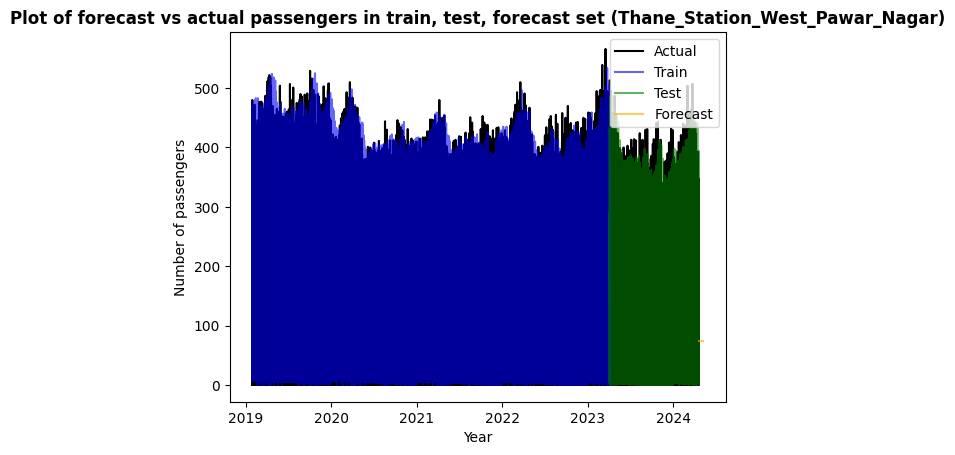

In [ ]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load the data
check = pd.read_csv('/kaggle/input/file5-pre-processing-data-pt2/File5 (2) - data pre-processing pt.2.csv')

# Replace hyphens, spaces, and slashes in the 'Station_Pair' column with underscores
check['Station_Pair'] = check['Station_Pair'].apply(lambda x: x.replace('-', '_'))
check['Station_Pair'] = check['Station_Pair'].apply(lambda x: x.replace(' ', '_'))
check['Station_Pair'] = check['Station_Pair'].apply(lambda x: x.replace('/', '_'))

# Define the station pair you are working with
sp = 'Thane_Station_West_Pawar_Nagar'

# Filter the DataFrame for the specific station pair
check = check[check['Station_Pair'] == sp]

# Create a date range and ensure it matches the length of the DataFrame
date_range = pd.date_range('2024-04-20 00:00', pd.Timestamp(2024, 5, 7, 23), freq='1H')
if len(date_range) != check.shape[0]:
    # Align the lengths by either truncating or extending the DataFrame
    if len(date_range) < check.shape[0]:
        check = check.iloc[:len(date_range)]
    else:
        additional_rows = pd.DataFrame({
            'Station_Pair': [sp] * (len(date_range) - check.shape[0]),
            'Date_Time': [pd.NaT] * (len(date_range) - check.shape[0]),
            'Passenger_Count': [0] * (len(date_range) - check.shape[0])
        })
        check = pd.concat([check, additional_rows], ignore_index=True)

# Assign the date range to the Date_Time column
check['Date_Time'] = date_range

# Define a custom function to create lag features
def create_lag_features(df, lag_vars, lags):
    for var in lag_vars:
        for lag in lags:
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)
    return df

forecast_df = check.copy()
forecast_df['Passenger_Count'] = 0
ref_date = forecast_df['Date_Time'].iloc[0] - pd.Timedelta(days=400)
temp = df_filter_2[(df_filter_2['Date_Time'] >= ref_date) & (df_filter_2['Station_Pair'] == sp)]
combined_df = pd.concat([temp, forecast_df], ignore_index=True)
index_start = combined_df[combined_df['Date_Time'] >= pd.Timestamp(2024, 4, 20)].index[0]
num_of_forecast = forecast_df.shape[0]

for index in range(num_of_forecast):
    temp = combined_df.loc[:index_start]

    # create lag features
    temp = create_lag_features(temp, lag_vars=['Passenger_Count'], lags=[1, 2, 24, 24*7, 24*14, 24*21, 24*28])
    temp.dropna(inplace=True)

    # create X
    X = temp.drop(columns=['Date_Time', 'Sid', 'Did', 'Station_Pair', 'Passenger_Count'])

    # normalizing test set & reshape
    sc_X = joblib.load(f'/kaggle/working/scaler_X_{sp}.joblib')
    X_scaled = sc_X.transform(X)
    X_scaled_2 = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

    # predict on test set
    model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
    pred_inverse = model.predict(X_scaled_2[-1, :, :].T)
    sc_y = joblib.load(f'/kaggle/working/scaler_y_{sp}.joblib')
    pred_2 = sc_y.inverse_transform(pred_inverse)
    pred = np.floor(pred_2)
    pred = np.where(pred < 0, 0, pred)
    combined_df.loc[index_start, 'Passenger_Count'] = pred[0][0]
    index_start += 1

combined_df[combined_df['Date_Time'] >= pd.Timestamp(2024, 4, 20)].to_csv(f'/kaggle/working/forecast_{sp}.csv')

# Load predictions
file1 = pd.read_csv(f"/kaggle/working/Thane_Station_West_Pawar_Nagar.csv")
pred = file1['Pred']
pred = np.where(pred < 0, 0, pred)

# Load the model for training predictions
model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
train_pred_inverse = model.predict(X_train_scaled_2)
train_pred_2 = sc_y.inverse_transform(train_pred_inverse)
train_pred = np.floor(train_pred_2)
train_pred = np.where(train_pred < 0, 0, train_pred)

# Load the forecast
forecast = pd.read_csv(f'/kaggle/working/forecast_{sp}.csv')
forecast['Date_Time'] = pd.date_range(pd.Timestamp(2024, 4, 20, 0, 0), pd.Timestamp(2024, 5, 7, 23, 0), freq='1H')

# Plot the results
plt.plot(df_one_station_pair_lag_2['Date_Time'].to_numpy(), df_one_station_pair_lag_2['Passenger_Count'].to_numpy(), c='black', label='Actual')
plt.plot(df_one_station_pair_lag_2.loc[X_train.index, 'Date_Time'].to_numpy(), train_pred, c='blue', label='Train', alpha=0.6)
plt.plot(df_one_station_pair_lag_2.loc[X_test.index, 'Date_Time'].to_numpy(), pred, c='green', label='Test', alpha=0.6)
plt.plot(forecast['Date_Time'].to_numpy(), forecast['Passenger_Count'], c='orange', label='Forecast', alpha=0.6)

plt.legend(loc=0)
plt.title(f'Plot of forecast vs actual passengers in train, test, forecast set ({sp})', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of passengers')
plt.savefig(f'/kaggle/working/{sp}.tiff', format='tiff', dpi=300, bbox_inches='tight')
